In [16]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
from tqdm import tqdm
import pandas as pd
import numpy as np

# Permutation Importance & Visualization
import eli5
from eli5.sklearn import PermutationImportance

# Scikit - learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import f1_score

# Data Scaling
from imblearn.over_sampling import BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# Visualization
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
import seaborn as sns

# Model & AutoML
import catboost
import optuna

In [17]:
### feature importance 무한히 돌리기
### threshold

# corr 그래프 등 시각화

In [18]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

In [19]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
subm = pd.read_csv('./sample_submission.csv')

In [20]:
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


In [21]:
train['PRODUCT_CODE'] = train['PRODUCT_CODE'].astype('category')
train['LINE'] = train['LINE'].astype('category')

test['PRODUCT_CODE'] = test['PRODUCT_CODE'].astype('category')
test['LINE'] = test['LINE'].astype('category')

In [22]:
# train에서 열의 유일한 값이 nan이거나 모두 같은 값인 경우 해당 열을 제외
def remove_col(train_df, test_df):
    for x in train_df.columns[6:]:
        if train_df[x].nunique()==0 or (train_df[x].nunique()==1 and len(train_df[x].unique())==1): # nan 이거나 모두 같은 값인 경우
            train_df.drop(columns=[x], inplace=True)
            test_df.drop(columns=[x], inplace=True)
    return train_df, test_df

In [23]:
train, test = remove_col(train, test)

In [24]:
train.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Quality'], inplace=True)

test = test[train.columns[1:]]

In [25]:
train_x, train_y = train.drop(columns=['Y_Class']), train['Y_Class']

In [26]:
train_x.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,NaN
1,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,NaN
2,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,NaN
3,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78,NaN
4,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97,NaN


### catboost cv

In [73]:
train_y.value_counts()

1    407
2    103
0     88
Name: Y_Class, dtype: int64

In [46]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type='GPU') # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

15it [06:01, 24.10s/it]

0.5811609030761885 : [0.14285714 0.68067227 0.68067227] ~ 0.7829945233454004 : [0.14285714 0.68067227 0.68067227]
mean : 0.6609634746016518


### Feature & Permutation importance

#### Feature Importance

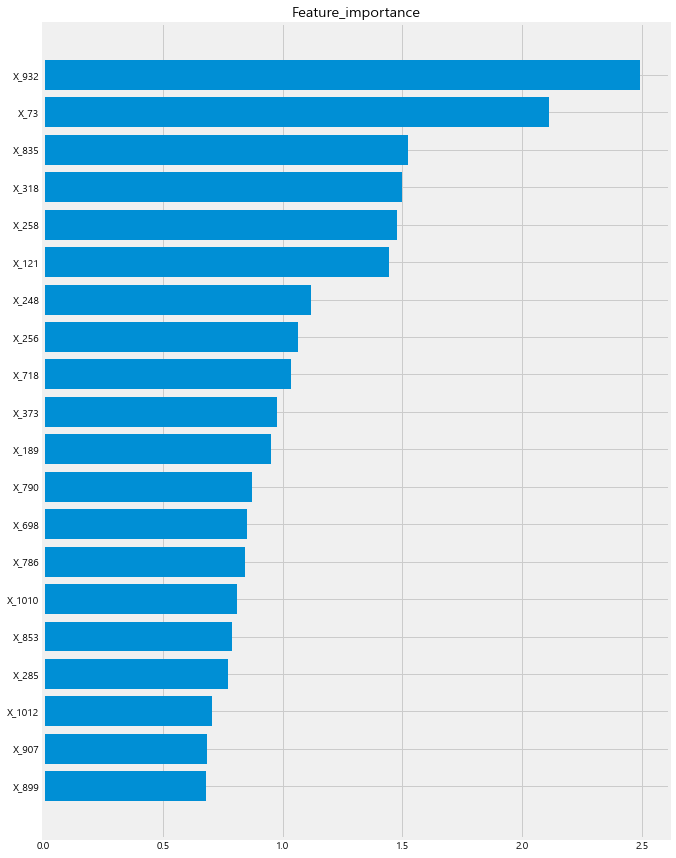

In [27]:
clf = catboost.CatBoostClassifier(verbose=0, task_type='GPU') # cpu -> thread_count=5
clf.fit(train_x, train_y, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])

feat = clf.feature_importances_
feature_imp = pd.Series(feat, index=train_x.columns).sort_values(ascending=False)[:20].sort_values()

plt.rcParams["figure.figsize"] = (10, 15)
plt.barh(feature_imp.index, feature_imp)
plt.title('Feature_importance')
plt.show()

In [28]:
# feature_importance > 0 인 컬럼만 선택
tmp = pd.Series(feat[feat > 0], index=train_x.columns[feat > 0]).sort_values(ascending=False)[:]
train_x = train_x[tmp.index]
test = test[train_x.columns]
train_x

,X_932,X_73,X_835,X_318,X_258,X_121,X_248,X_256,X_718,X_373,...,X_1440,X_1888,X_1758,X_1940,X_2105,X_394,X_1832,X_1936,X_1924,X_1762
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2269.0,0.00000,0.706138,0.000000,0.000008,NaN,1.414252,0.000000,0.0,0.036773
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2270.0,0.07315,1.159383,0.149803,0.000003,NaN,1.363817,0.091822,0.0,0.062509
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2267.0,0.00000,0.749829,0.000000,0.000009,NaN,1.418331,0.000000,0.0,0.030454
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2268.0,0.00000,1.149621,0.000000,0.000002,NaN,1.416721,0.000000,0.0,0.064830
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2271.0,0.00000,0.676211,0.000000,0.000008,NaN,1.418331,0.000000,0.0,0.029483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,13.351613,10.09,9.096774,NaN,NaN,34.1,NaN,NaN,16.967742,NaN,...,NaN,NaN,NaN,NaN,NaN,-60.0,NaN,NaN,NaN,NaN
594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2296.0,0.00000,0.679252,0.000000,NaN,NaN,1.410926,0.000000,0.0,0.019844
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2294.0,0.00000,0.649743,0.000000,NaN,NaN,1.422233,0.000000,0.0,0.027558
596,13.406667,10.22,9.533333,NaN,NaN,33.7,NaN,NaN,18.633333,NaN,...,NaN,NaN,NaN,NaN,NaN,-20.0,NaN,NaN,NaN,NaN


In [14]:
# while 1:
#     clf = catboost.CatBoostClassifier(verbose=0, task_type='GPU') # cpu -> thread_count=5
#     clf.fit(train_x, train_y, early_stopping_rounds=100)
    
#     feat = clf.feature_importances_
#     tmp = pd.Series(feat[feat > 0], index=train_x.columns[feat > 0]).sort_values(ascending=False)[:]
#     if len(tmp) == len(train_x.columns):
#         break
#     print('col cnt :', len(tmp))
#     train_x = train_x[tmp.index]
# test = test[train_x.columns]

col cnt : 800
col cnt : 710



KeyboardInterrupt



In [28]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
class_rate = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5, gpu -> task_type="GPU"
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    class_rate.append(np.array([len(y_val[y_val==0]), len(y_val[y_val==1]), len(y_val[y_val==1])]) / len(y_val))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

25it [04:56, 11.86s/it]

0.6195245919596889 ~ 0.7974871547848427
mean : 0.6965416058252865


In [72]:
pred = []
for proba in clf.predict_proba(x_val):
    if list(proba).index(max(proba)) == 1 and max(proba) < 0.7:
        if proba[0] > proba[2]: 
            pred.append(0)
        elif proba[0] < proba[2]:
            pred.append(2)
        else:
            pred.append(1)
    else:
        pred.append(list(proba).index(max(proba)))
        
print(f1_score(pred, y_val, average='macro'))

print(f1_score(clf.predict(x_val), y_val, average='macro'))

0.7665665665665666
0.688506923129391


In [ ]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list, f1t_list = [], []
cnt = 0
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5, gpu -> task_type="GPU"
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    
    threshold = 0.5 # 0.6->22 0.686, 0.65 -> 17, 0.75 -> 14, 0.7 -> 16
    pred = []
    for proba in clf.predict_proba(x_val):
        if list(proba).index(max(proba)) == 1 and max(proba) < threshold:
            if proba[0] > proba[2]: 
                pred.append(0)
            elif proba[0] < proba[2]:
                pred.append(2)
            else:
                pred.append(1)
        else:
            pred.append(list(proba).index(max(proba)))

    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    f1t_list.append(f1_score(pred, y_val, average='macro'))
    if f1_score(pred, y_val, average='macro') >= f1_score(clf.predict(x_val), y_val, average='macro'):
        cnt += 1

print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))
print()

print(cnt, '/ 25')
print(f'{min(f1t_list)} ~ {max(f1t_list)}')
print('mean :', np.mean(f1t_list))

0it [00:00, ?it/s]

#### Permutation Importance

In [ ]:
# Permutation Importance는 영향력을 확인하는 것이다. column이 매우 많은 상황에서 score에 대한 영향력을 확인하는 것도 좋지만,
# 결측치가 많고, test set에서 해당 columns이 어떤 상황일지 모르는 데 이 과정을 통해 column을 제거하는 것은 부정적인 영향을 줄 수 있다.

In [11]:
# col = ["X_368", "X_367", "X_248", "X_73", "X_1569", "X_258", "X_318", "X_932", "X_380", "X_993", "X_1665", "X_1518", "X_899", "X_121", "X_1812", "X_1697", "X_1330", "X_1108", "X_1333", "X_120", "X_968", "X_1135", "X_1560", "X_1155", "X_1033", "X_556", "X_848", "X_1433", "X_517", "X_1346", "X_1202", "X_423", "X_1716", "X_718", "X_354", "X_1089", "X_497", "X_1473", "X_571", "X_2862", "X_983", "X_838", "X_374", "X_790", "X_1406", "X_942", "X_1378", "X_1214", "X_1424", "X_1172", "X_1129", "X_1122", "X_662", "X_1101", "X_985", "X_967", "X_815", "X_1058", "X_956", "X_1054", "X_1047", "X_1076", "X_1292", "X_2432", "X_346", "X_2791", "X_1610", "X_2794", "X_475", "X_2780", "X_286", "X_189", "X_256", "X_462", "X_62", "X_1389", "X_484", "X_388", "X_1350", "X_1740", "X_1471", "X_792", "X_949", "X_1509", "X_788", "X_1081", "X_1082", "X_963", "X_1373", "X_1631", "X_915", "X_997", "X_678", "X_1107", "X_422", "X_1335", "X_618", "X_1240", "X_1231", "X_1696", "X_995", "X_1557", "X_437", "X_1343", "X_1743", "X_1176", "X_90", "X_1647", "X_994", "X_825", "X_1512", "X_927", "X_1094", "X_926", "X_257", "X_1116", "X_397", "X_345", "X_894", "X_1211", "X_460", "X_1365", "X_810", "X_536", "X_1492", "X_2048", "X_1640", "X_574", "X_491", "X_660", "X_1351", "X_339", "X_651", "X_287", "X_616", "X_379", "X_668", "X_1366", "X_1532", "X_1642", "X_1213", "X_1551", "X_49", "X_1260", "X_1169", "X_1636", "X_820", "X_1059", "X_780", "X_2026", "X_2050", "X_490", "X_679", "X_661", "X_492", "X_581", "X_1416", "X_495", "X_2096", "X_553", "X_552", "X_1421", "X_506", "X_795", "X_706", "X_1548", "X_1048", "X_457", "X_901", "X_918", "X_922", "X_1530", "X_533", "X_897", "X_2702", "X_418", "X_417", "X_1752", "X_613", "X_982", "X_373", "X_1744", "X_1353", "X_1616", "X_698", "X_456", "X_1149", "X_1026", "X_45", "X_61", "X_2797", "X_529", "X_266", "X_712", "X_439", "X_603", "X_1243", "X_546", "X_2542", "X_1638", "X_2626", "X_2455", "X_2704", "X_2471", "X_2221", "X_2347", "X_2346", "X_2275", "X_2122", "X_2086", "X_2079", "X_2019", "X_1951", "X_1854", "X_1850", "X_1804", "X_1858", "X_984", "X_1475", "X_474", "X_667", "X_555", "X_544", "X_543", "X_539", "X_515", "X_502", "X_493", "X_468", "X_714", "X_465", "X_448", "X_436", "X_265", "X_139", "X_126", "X_110", "X_101", "X_1289", "X_710", "X_769", "X_1127", "X_1275", "X_819", "X_827", "X_1205", "X_855", "X_22", "X_1163", "X_1063", "X_791", "X_1111", "X_1112", "X_1113", "X_1114", "X_1014", "X_2467", "X_12", "X_1179", "X_835", "X_572", "X_1000"]
# train_x = train_x[col]
# test_x = test[col]

In [47]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)

perm_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE']) # Feature_importance에서 LINE이 제거됨

    perm = PermutationImportance(clf).fit(x_val, y_val) # n_iter = 1
    perm_list.append(perm.feature_importances_)
    
eli5.show_weights(perm, feature_names = x_val.columns.tolist())

5it [2:31:27, 1817.44s/it]


Weight,Feature
0.0252 ± 0.0106,X_1743
0.0168 ± 0.0106,X_932
0.0168 ± 0.0000,X_367
0.0151 ± 0.0126,X_1744
0.0151 ± 0.0126,X_368
0.0151 ± 0.0067,X_121
0.0151 ± 0.0067,X_120
0.0118 ± 0.0082,X_73
0.0101 ± 0.0067,X_1569
0.0101 ± 0.0067,X_1716


In [48]:
perm_list = np.array(perm_list)
perm_mean = np.array([np.mean(perm_list[:, i]) for i in range(len(perm_list[0]))])
tmp = pd.Series(perm_mean[(perm_mean > 0)], index=train_x.columns[(perm_mean > 0)]).sort_values(ascending=False)[:]
train_x = train_x[tmp.index]
test = test[train_x.columns]
train_x

,X_368,X_367,X_248,X_73,X_1569,X_258,X_318,X_932,X_380,X_993,...,X_1112,X_1113,X_1114,X_1014,X_2467,X_12,X_1179,X_835,X_572,X_1000
0,NaN,NaN,NaN,NaN,486.677419,NaN,NaN,NaN,0.0,102.0,...,211.925926,84.111111,3.500000,404.0,35.0,NaN,20.0,NaN,NaN,411.0
1,NaN,NaN,NaN,NaN,486.593750,NaN,NaN,NaN,0.0,103.0,...,211.981132,84.396226,3.500000,395.0,36.0,NaN,21.0,NaN,NaN,414.0
2,NaN,NaN,NaN,NaN,486.645161,NaN,NaN,NaN,0.0,103.0,...,212.018868,84.018868,3.500000,407.0,34.7,NaN,22.0,NaN,NaN,417.0
3,NaN,NaN,NaN,NaN,486.531250,NaN,NaN,NaN,0.0,104.0,...,211.962264,84.320755,3.500000,397.0,35.8,NaN,22.0,NaN,NaN,421.0
4,NaN,NaN,NaN,NaN,486.935484,NaN,NaN,NaN,0.0,109.0,...,212.111111,85.203704,3.500000,420.0,34.6,NaN,22.0,NaN,NaN,441.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,NaN,NaN,NaN,10.09,NaN,NaN,NaN,13.351613,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,473.9,NaN,9.096774,21.0,NaN
594,NaN,NaN,NaN,NaN,486.612903,NaN,NaN,NaN,3.0,296.0,...,212.056604,85.037736,3.418868,419.0,35.6,NaN,23.0,NaN,NaN,1384.0
595,NaN,NaN,NaN,NaN,486.677419,NaN,NaN,NaN,3.0,298.0,...,212.132076,84.792453,3.433962,428.0,35.6,NaN,21.0,NaN,NaN,1393.0
596,NaN,NaN,NaN,10.22,NaN,NaN,NaN,13.406667,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,510.9,NaN,9.533333,20.0,NaN


In [12]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5, gpu -> task_type="GPU"
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

25it [04:27, 10.71s/it]

0.639344766119614 : [0.15       0.68333333 0.68333333] ~ 0.8053274949826674 : [0.15       0.68333333 0.68333333]
mean : 0.7111273645948281


### 결측치 대체

#### fillna(0)

In [29]:
train_x.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [32]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

25it [04:57, 11.89s/it]

0.5946844319775596 ~ 0.7632555715889048
mean : 0.6956812485682076


### Data Scaling (random, SMOTE ENN, SMOTE Tomek, ADASYN, Borderline SMOTE)

In [33]:
def Randomoversampler(train_x_df, train_y_df):
    x_ros, y_ros = RandomOverSampler().fit_resample(train_x_df, train_y_df)
    return x_ros, y_ros

In [34]:
def SMOTE_Tomek(train_x_df, train_y_df):
    x_smoteenn, y_smoteenn = SMOTETomek().fit_resample(train_x_df, train_y_df)
    return x_smoteenn, y_smoteenn

In [35]:
def SMOTE_ENN(train_x_df, train_y_df):
    x_smoteenn, y_smoteenn = SMOTEENN().fit_resample(train_x_df, train_y_df)
    return x_smoteenn, y_smoteenn

In [36]:
def ADASYN_(train_x_df, train_y_df):
    x_adasyn, y_adasyn = ADASYN(sampling_strategy='minority').fit_resample(train_x_df, train_y_df)
    return x_adasyn, y_adasyn

In [37]:
def Borderline_SMOTE(train_x_df, train_y_df):
    x_b_smote, y_b_smote = BorderlineSMOTE().fit_resample(train_x_df, train_y_df)
    return x_b_smote, y_b_smote

#### RandomOverSampling

In [38]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
    x_trn, y_trn = Randomoversampler(x_trn, y_trn)
    
    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

25it [04:50, 11.60s/it]

0.5301796180752505 ~ 0.8287868354609178
mean : 0.6706828915230093


#### SMOTE_ENN

In [39]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
    x_trn, y_trn = SMOTE_ENN(x_trn, y_trn)
    
    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

25it [05:04, 12.18s/it]

0.4748017083587553 ~ 0.6831617942729054
mean : 0.5846311983159844


#### SMOTE_Tomek

In [40]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
    x_trn, y_trn = SMOTE_Tomek(x_trn, y_trn)
    
    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

25it [05:31, 13.24s/it]

0.5595878136200716 ~ 0.7641108495283818
mean : 0.6652897385505305


#### ADASYN

In [41]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
    x_trn, y_trn = ADASYN_(x_trn, y_trn)
    
    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

25it [05:18, 12.74s/it]

0.569729683960966 ~ 0.763031391990668
mean : 0.6790796785060819


#### BorderlineSMOTE

In [42]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
    x_trn, y_trn = Borderline_SMOTE(x_trn, y_trn)
    
    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

25it [05:32, 13.30s/it]

0.5720253529242293 ~ 0.788464737192282
mean : 0.6945455511397514


In [81]:
# train_x.to_csv('train_x_pp.csv', index=False)
# train_y.to_csv('train_y_pp.csv', index=False)
# test.to_csv('test_pp.csv', index=False)

In [68]:
def cb_objective(trial):

    params = {
            'iterations':trial.suggest_int("iterations", 500, 3000),
            'objective':trial.suggest_categorical('objective',['MultiClass']),
            #'bootstrap_type':trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
            'od_wait':trial.suggest_int('od_wait', 500, 1000),
            'learning_rate' : trial.suggest_uniform('learning_rate',0.01,1),
            'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
            'random_strength': trial.suggest_uniform('random_strength',20,50),
            'depth': trial.suggest_int('depth',1,15),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,20),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
            'verbose': False,
            "eval_metric":'TotalF1',
            #"cat_features" : ['PRODUCT_CODE', 'LINE'],
            "one_hot_max_size": trial.suggest_int("one_hot_max_size",1,5),
            'task_type' : 'GPU',
            #'thread_count': 5,
        }

#     if params['bootstrap_type'] == 'Bayesian':
#         params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
#     elif params['bootstrap_type'] == 'Bernoulli':
#         params['subsample'] = trial.suggest_float('subsample', 0.1, 1)
    
    rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
    clf = catboost.CatBoostClassifier(**params)

    f1_list = []
    for fold, (train_index, val_index) in enumerate(rskfold.split(train_x, train_y)):
        x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
        x_trn, y_trn = ADASYN_(x_trn, y_trn)
        
        clf.fit(x_trn, y_trn, early_stopping_rounds=100)
        f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
        print(1)
    
    return np.mean(f1_list)

In [69]:
study = optuna.create_study(direction='maximize')
study.optimize(cb_objective, n_trials=30, show_progress_bar=True)

[I 2023-02-17 01:19:40,193] A new study created in memory with name: no-name-333da0bb-b053-46ac-87ff-d36dc825c2c1


  0%|          | 0/30 [00:00<?, ?it/s]


KeyboardInterrupt



In [86]:
print(study.best_trial)
print(study.best_params)

{'iterations': 1337,
 'objective': 'MultiClass',
 'bootstrap_type': 'Bayesian',
 'od_wait': 552,
 'learning_rate': 0.6128454724915484,
 'reg_lambda': 77.08090755141544,
 'random_strength': 43.1413895840195,
 'depth': 3,
 'min_data_in_leaf': 20,
 'leaf_estimation_iterations': 2,
 'one_hot_max_size': 1,
 'bagging_temperature': 0.06040383536784377}

In [70]:
clf = catboost.CatBoostClassifier(**study.best_params, verbose=0).fit(train_x, train_y)
pred = clf.predict(test)
subm['Y_Class'] = pred

In [80]:
subm.Y_Class.value_counts()

1    264
0     39
2      7
Name: Y_Class, dtype: int64

In [81]:
subm.to_csv('./submission_36_feat_del.csv', index=False)